## Classification of Physical Behaviour
### Smartphone-based locomotion and transportation recognition

--------------------------------
--------------------------------

### Overview

For this example, data from smarthpone sensors (placed on the hip) will be used to build a model for predicting locomotion and transportation activities. To that end, the [SHL dataset](http://www.shl-dataset.org/download/#shldataset-preview) will be used to predict the following activities: 
'Still', 'Walking','Run', 'Bike', 'Car', 'Bus', 'Train', and 'Subway'.

In order to build and evaluate an activity recognition system, a sequence of steps is required. 
These steps include data  acquisition,  data  processing,  data segmentation, features extraction, data imputation, features selection, classification, and validation. The following lines of code are performed with Python.

### Methodology

1. **Data Acquisition**: Based on literature, it is highly recommended to use sensor data related to accelerometer, gyroscpose and GPS location for predicting activities related to locomotion and transportation. Here, the focus will be on accelerometer, gyroscope, magnetometer, and GPS data obtained from the [SHL dataset](http://www.shl-dataset.org/download/#shldataset-preview).
2. **Data Processing**: Here data are cleaned and prepared for the next phases. Furthermore, GPS data features (i.e., speed and distance) are calculated based on the Haversine Distance of the GPS coordinates. 
3. **Data Segmentation**: here the sensor data are divided into different frames. Based on literature, it is recommended a window segment of ~5sec with 50% overlap. Here, a sliding window of size 6 seconds with half overlap is chosen to meet the criteria for sensor fusion (by merging motion data and GPS).
4. **Features Extraction**: different time and frequency domain features are extracted for each sensor recording. Based on literature, I decided to compute the following features. For the accelerometer
I computed mean, std, magnitude, fftfreq (peak frequencies based on fast fourier), signal power, entropy. For the gyroscope I computed mean, std, and magnitude. For the magnetomer I computed std, magnitude. For the GPS I computed the mean values. A description of these features can be found on the following section (see Reference [1](https://repository.tudelft.nl/islandora/object/uuid%3Aaf2e1786-ccc4-4592-afc8-b19819544f26)). Furthermore, missing GPS data are imputed. 
5. **Features Selection**: here non-informative features are excluded. At first highly correlated features (with an absolute correlation >=0.9) are removed. Then, a feature selection model (based on sklearn feature importance score) is also used to remove features with the lowest information gain.
6. **Classification**: The Random Forest is used to train the prediction model. Since the focus is not on how to optimise the classificaiton model, I will not focus on optimising the hyperparameters or on evaluating other algorithms.
7. **Validation**: The StratifiedShuffleSplit split from sklearn is used to split the data into 10 different train/test sets (10-fold cross- validation). Different metrics are used, such as precision, recall, f1-score, and confusion matrix.

### Background Information & Related Work
For this solution, different studies in literature were considered. Mainly, I focused on the followings:
1. [Physical Activity Recognition using Wearable Accelerometers in Controlled and Free-Living Environments](https://repository.tudelft.nl/islandora/object/uuid%3Aaf2e1786-ccc4-4592-afc8-b19819544f26) (my MSc thesis graduation project about activity recognition)
2. [A systematic review of smartphone-based human activity recognition methods for health research](https://www.nature.com/articles/s41746-021-00514-4)
3. [The University of Sussex-Huawei Locomotion and
Transportation Dataset for Multimodal Analytics
With Mobile Devices](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8418369)


### Import Libraries in Python

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from os.path import dirname, join as pjoin
import os
import glob

import scipy.io as sio 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import r2_score
import matplotlib.dates as dates
import matplotlib.ticker as ticker

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


### Read Data 

Three different files are obtained based on the SHL Dataset (sensors lotated on the hip).
1. The **Label.txt** includes annotated activities.
2. The **Hips_Location.txt** includes GPS coordinates.
3. The **Hips_Motion.txt** includes smartphone sensor recordings.

In [2]:
#check folder path /SHL Dataset/SHLDataset_preview_v1/User1/
path = os.path.dirname(os.getcwd())
file_location = path+'/data/SHL Dataset/SHLDataset_preview_v1/User1/'

folder_list = ['220617', '260617', '270617']
user1_label = pd.DataFrame()
user1_hips_location = pd.DataFrame()
user1_hips_motion = pd.DataFrame()

#read data from SHL Dataset 
for folder_name in folder_list:
    print (folder_name)
    
    #read data related to annotated activities
    data_label = pd.read_csv(file_location+folder_name+'/Label.txt', sep=" ", header=None)
    data_label.columns = ['time', 'coarse_label', 'fine_label', 'road_label', 'traffic_label', 'tunnels_label', 'social_label', 'food_label' ]
    data_label['session_id'] = folder_name
    user1_label = user1_label.append(data_label, ignore_index = True)
    
    #read data related to hips_location
    df_hips_location = pd.read_csv(file_location+folder_name+'/Hips_Location.txt', sep=" ", header=None)
    df_hips_location.columns = ['time', 'ignore', 'ignore', 'location_accuracy', 'latitude', 'longitude', 'altitude' ]
    df_hips_location['session_id'] = folder_name
    user1_hips_location = user1_hips_location.append(df_hips_location, ignore_index = True)
    
    #read data related to hips_motion
    df_hips_motion = pd.read_csv(file_location+folder_name+'/Hips_Motion.txt', sep=" ", header=None)
    df_hips_motion.columns = ['time', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                             'magnetometer_x', 'magnetometer_y', 'magnetometer_z', 'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z',
                             'gravity_x', 'gravity_y', 'gravity_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
                             'pressure', 'altitude', 'temperature']
    df_hips_motion['session_id'] = folder_name
    user1_hips_motion = user1_hips_motion.append(df_hips_motion, ignore_index = True)


220617
260617
270617


#### Processing Data for 'user1_label'

In [3]:
#sort values by time (in case there is an error)
user1_label = user1_label.sort_values(by='time', ascending=True, na_position='first')

#convert time feature to datetime and makes it index
user1_label = user1_label.set_index(pd.to_datetime(user1_label['time'].astype(np.int64), unit='ms'))
user1_label.head(2)

,time,coarse_label,fine_label,road_label,traffic_label,tunnels_label,social_label,food_label,session_id
time,,,,,,,,,
2017-06-22 08:31:38.000,1498120298000,0,0,0,0,0,0,0,220617
2017-06-22 08:31:38.010,1498120298010,0,0,0,0,0,0,0,220617


In [4]:
#check the column types
user1_label.dtypes

time              int64
coarse_label      int64
fine_label        int64
road_label        int64
traffic_label     int64
tunnels_label     int64
social_label      int64
food_label        int64
session_id       object
dtype: object

#### Processing Data for 'user1_hips_motion'

In [5]:
#sort values by time (in case there is an error)
user1_hips_motion = user1_hips_motion.sort_values(by='time', ascending=True, na_position='first')

#convert time feature to datetime and makes it index
user1_hips_motion = user1_hips_motion.set_index(pd.to_datetime(user1_hips_motion['time'].astype(np.int64), unit='ms'))
user1_hips_motion.head(2)

,time,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,magnetometer_x,magnetometer_y,magnetometer_z,...,gravity_x,gravity_y,gravity_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,pressure,altitude,temperature,session_id
time,,,,,,,,,,,,,,,,,,,,,
2017-06-22 08:31:38.000,1.498120e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220617
2017-06-22 08:31:38.010,1.498120e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220617


In [6]:
#check the column types
user1_hips_motion.dtypes

time                     float64
acceleration_x           float64
acceleration_y           float64
acceleration_z           float64
gyroscope_x              float64
gyroscope_y              float64
gyroscope_z              float64
magnetometer_x           float64
magnetometer_y           float64
magnetometer_z           float64
orientation_w            float64
orientation_x            float64
orientation_y            float64
orientation_z            float64
gravity_x                float64
gravity_y                float64
gravity_z                float64
linear_acceleration_x    float64
linear_acceleration_y    float64
linear_acceleration_z    float64
pressure                 float64
altitude                 float64
temperature              float64
session_id                object
dtype: object

#### Processing Data for 'user1_hips_location'

In [7]:
#sort values by time (in case there is an error)
user1_hips_location = user1_hips_location.sort_values(by='time', ascending=True, na_position='first')

#convert time feature to datetime and makes it index
user1_hips_location = user1_hips_location.set_index(pd.to_datetime(user1_hips_location['time'].astype(np.int64), unit='ms'))
user1_hips_location.head(2)

,time,ignore,ignore,location_accuracy,latitude,longitude,altitude,session_id
time,,,,,,,,
2017-06-22 08:40:10.872,1498120810872,610920350946,58208616136,350.0,50.846145,-0.137434,-354.525315,220617
2017-06-22 08:40:11.883,1498120811883,611921629592,58208616136,350.0,50.847710,-0.130524,369.113523,220617


In [8]:
#check the column types
user1_hips_location.dtypes

time                   int64
ignore                 int64
ignore                 int64
location_accuracy    float64
latitude             float64
longitude            float64
altitude             float64
session_id            object
dtype: object

In [9]:
def GPS_distance_speed(df):
    """                                                                                                                 
    Calculates the instantaneous speed from the GPS positions and timestamps based on the formula of Haversine Distance. 
    The distances between the points are calculated using a vectorized haversine calculation the great circle distance between two arrays of points on   
    the earth (specified in decimal degrees). 
    Haversine Distance can be defined as the angular distance between two locations on the Earth’s surface.
    All args must be of equal length.                                         
 
    Related Work:
    (1) https://www.tjansson.dk/2021/03/vectorized-gps-distance-speed-calculation-for-pandas/ 
    (2) https://janakiev.com/blog/gps-points-distance-python/ 
    Args:                                                                                                               
        dataframe df with GPS coordinates                                                                        
 
    Returns:                                                                                                            
        the initial dataframe, including Speed (km/h) and Distance (km)                                                                        
 
    Example:                                                                                                            
        >>> GPS_df = GPS_distance_speed(GPS_df)
    """             
    GPS_df = df.copy()
    longitudes = GPS_df['longitude'].squeeze()                                                                                    
    latitudes = GPS_df['latitude'].squeeze()                                                                                       
    
    assert longitudes.shape[0] > 1                                                                                      
    assert latitudes.shape[0] > 1                                                                                       
 
    lon1 = longitudes.values[:-1]                                                                                     
    lat1 = latitudes.values[:-1]                                                                                
    lon2 = longitudes.values[1:]                                                                                  
    lat2 = latitudes.values[1:]
         
    #radius of Earth in meters    
    R=6371000
    
    # Vectorized haversine calculation                                                                                  
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])                                                  
    a = np.sin((lat2 - lat1) / 2.0)**2 + (np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1) / 2.0)**2)                 
    
    #output distance in kilometers
    distance = R * 2 * np.arcsin(np.sqrt(a)) 
    km = distance/1000
    
    GPS_df['datetime'] = pd.to_datetime(GPS_df['time'], unit='ms')
    time_array = (GPS_df['datetime'].diff().dt.seconds/60).values[1:]  #calculate hours 
       
    # Calculate the speed                                                                                               
    time_array[time_array == 0] = np.nan  # To avoid division by zero                                                   
    speed = km / time_array 
    
    speed = np.insert(speed, 0, np.nan, axis=0)                                                                         
    km = np.insert(km, 0, np.nan, axis=0) 
    
    GPS_df['distance_km'] = np.round(km, 4)
    GPS_df['speed'] = speed
    
    return GPS_df


#calculate GPS features distance and speed based on the GPS_distance_speed function
folder_list = ['220617', '260617', '270617']
user1_hips_GPS = pd.DataFrame()

for folder_name in folder_list:
    print (folder_name)
    
    #select only data for different session_id (seperate recording days)
    user1_hips_GPS_mask = user1_hips_location.loc[user1_hips_location['session_id']== folder_name]
    #call GPS_distance_speed function
    user1_hips_GPS_mask = GPS_distance_speed(user1_hips_GPS_mask)
    #append data for all the recordng days
    user1_hips_GPS = user1_hips_GPS.append(user1_hips_GPS_mask, ignore_index = False)
    
user1_hips_GPS.head(5)

220617
260617
270617


,time,ignore,ignore,location_accuracy,latitude,longitude,altitude,session_id,datetime,distance_km,speed
time,,,,,,,,,,,
2017-06-22 08:40:10.872,1498120810872,610920350946,58208616136,350.0,50.846145,-0.137434,-354.525315,220617,2017-06-22 08:40:10.872,NaN,NaN
2017-06-22 08:40:11.883,1498120811883,611921629592,58208616136,350.0,50.847710,-0.130524,369.113523,220617,2017-06-22 08:40:11.883,0.5155,30.927081
2017-06-22 08:40:12.885,1498120812885,612953338446,58208616136,350.0,50.846167,-0.137324,-345.342402,220617,2017-06-22 08:40:12.885,0.5073,30.440694
2017-06-22 08:40:13.887,1498120813887,613956204591,58208616136,200.0,50.846212,-0.137121,11.013710,220617,2017-06-22 08:40:13.887,0.0151,0.908739
2017-06-22 08:40:14.889,1498120814889,614958479591,58208616136,200.0,50.846233,-0.137009,-57.376872,220617,2017-06-22 08:40:14.889,0.0082,0.490282


### Data Exploration (Visualisation)

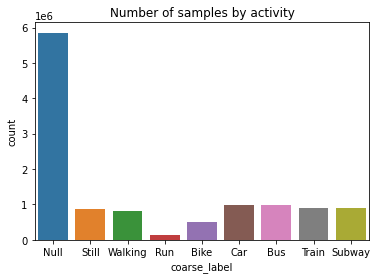

In [10]:
#plot the total number for each annotated activity
sns.countplot(data = user1_label, x = 'coarse_label')
activities = ['Null', 'Still', 'Walking','Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
plt.title('Number of samples by activity')
plt.xticks(np.arange(0,9), activities)
plt.show()

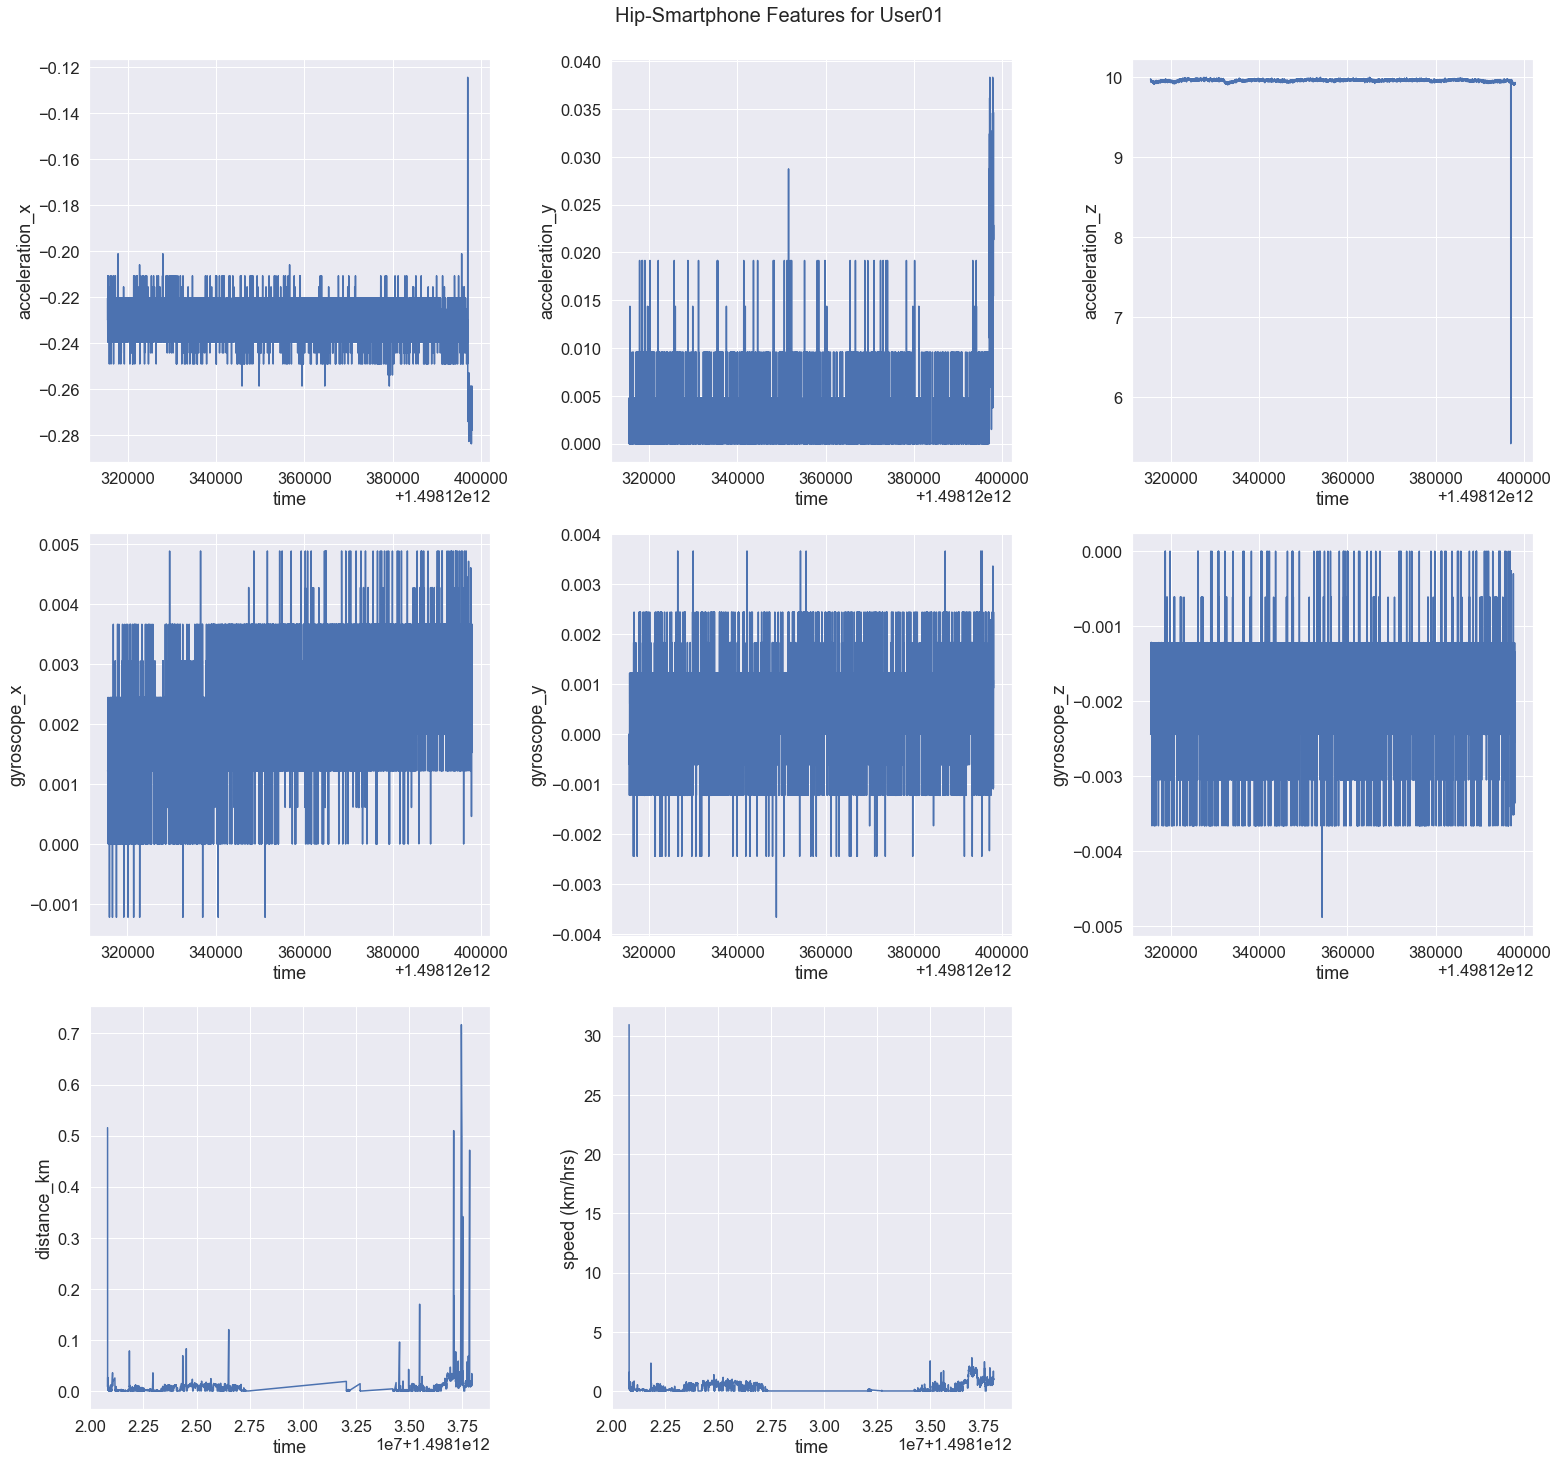

In [11]:
#for visualising purposes, I only plot the first 10000 rows
sns.set_theme(font_scale=1.5)

fig = plt.figure(figsize=(22, 20))

sub1 = fig.add_subplot(3,3,1)
sub2 = fig.add_subplot(3,3,2)
sub3 = fig.add_subplot(3,3,3)

sns.lineplot(data=user1_hips_motion.iloc[0:10000,:], x="time", y="acceleration_x", ax=sub1)
sns.lineplot(data=user1_hips_motion.iloc[0:10000,:], x="time", y="acceleration_y", ax=sub2)
sns.lineplot(data=user1_hips_motion.iloc[0:10000,:], x="time", y="acceleration_z", ax=sub3)

sub4 = fig.add_subplot(3,3,4)
sub5 = fig.add_subplot(3,3,5)
sub6 = fig.add_subplot(3,3,6)

sns.lineplot(data=user1_hips_motion.iloc[0:10000,:], x="time", y="gyroscope_x", ax=sub4)
sns.lineplot(data=user1_hips_motion.iloc[0:10000,:], x="time", y="gyroscope_y", ax=sub5)
sns.lineplot(data=user1_hips_motion.iloc[0:10000,:], x="time", y="gyroscope_z", ax=sub6)

sub7 = fig.add_subplot(3,3,7)
sub8 = fig.add_subplot(3,3,8)
sub8.set_ylabel("speed (km/hrs)")

sns.lineplot(data=user1_hips_GPS.iloc[0:10000,:], x="time", y="distance_km", ax=sub7)
sns.lineplot(data=user1_hips_GPS.iloc[0:10000,:], x="time", y="speed", ax=sub8)
 
fig.set_facecolor('w')
plt.tight_layout()
plt.rc('legend', loc="upper right", title_fontsize="small")
fig.suptitle("Hip-Smartphone Features for User01", y=1.02, fontsize=20)
plt.show()


### Data Segmentation & Features Extraction

Time and frequency domain features are extracted based on a window segment.
Based on literature, it is recommended to use a window size of 5.12 sec with 50% overlap.
Overall, it is recommended a smaller window size (1-5 sec) for capturing more complicated tasks (i.e., body postures), while a larger window size (5-10 sec) is required for capturing location and transportation data.

For this dataset, the sampling frequency is fs = 100Hz for the motion data and fs = 1Hz for the location (GPS) data. Therefore, in order to meet the sensor fusion criteria, I used a window size of 6 sec with 3 sec overlap.

In [12]:
def rolling(df, funcs, window_size, overlap):
    """Performs rolling features extraction for data frame df 
    with window length `window_size` and overlap `overlap`.
     
    Arguments:
 
    * `df`          : data frame
    * `funcs`       : a function or a list of functions 
                      to extract features from single window
    * `window_size` : window size in #samples
    * `overlap`     : overlap of consecutive windows in samples
    """
    if type(funcs) is not list:
        funcs = [funcs]
    N, d = df.shape
    features = [] 
    for func in funcs:
        #features.append(pd.concat([func(df[i:i+window_size]) for i in range(0, N-window_size, overlap)]))
        features.append(pd.concat([func(df[i:i+window_size]) for i in range(0, N-window_size, overlap)]))
     
    dfs = pd.concat(features, axis=1)
    return dfs

#this needs to be imported in order to read the related functions
#the features_extraction_all.py file includes the functions for statistical and frequency domain features
import features_extraction_all

fs_smartphone=100
window_length = 6 #literature recommented 5.12 (without GPS)
overlap=int(window_length/2) 

folder_list = ['220617', '260617', '270617']
user1_data = pd.DataFrame()

for folder_name in folder_list:
    print (folder_name)
    
    #extract only GPS related features for seperate recording days
    user1_hips_GPS_mask = user1_hips_GPS.loc[user1_hips_GPS['session_id']== folder_name]
    #call rolling function
    GPS_features = [features_extraction_all.mean]
    user1_hips_GPS_features = rolling(user1_hips_GPS_mask[['distance_km', 'speed']], GPS_features, window_length, overlap)
    #user1_hips_GPS_features = rolling(user1_hips_GPS_mask[['speed']], GPS_features, window_length, overlap)

    
    #extract only acc related features for seperate recording days
    user1_hips_motion_mask = user1_hips_motion.loc[user1_hips_motion['session_id']== folder_name]
    #call rolling function
    acc_features = [features_extraction_all.mean, features_extraction_all.std, features_extraction_all.magnitude,
                   features_extraction_all.fftfreq, features_extraction_all.signalpower, features_extraction_all.entropy]
    user1_hips_acc_features = rolling(user1_hips_motion_mask[['acceleration_x', 'acceleration_y', 'acceleration_z']], acc_features, int(window_length*fs_smartphone),int(overlap*fs_smartphone))
    
    #extract only gyroscope related features for seperate recording days
    #call rolling function
    gyroscope_features = [features_extraction_all.mean, features_extraction_all.std, features_extraction_all.magnitude]
    user1_hips_gyroscope_features = rolling(user1_hips_motion_mask[['gyroscope_x', 'gyroscope_y', 'gyroscope_z']], gyroscope_features, int(window_length*fs_smartphone),int(overlap*fs_smartphone))
    
    #extract only magnetometer related features for seperate recording days
    #call rolling function
    magnetometer_features = [features_extraction_all.std, features_extraction_all.magnitude]
    user1_hips_magnetometer_features = rolling(user1_hips_motion_mask[['magnetometer_x', 'magnetometer_y', 'magnetometer_z']], magnetometer_features, int(window_length*fs_smartphone),int(overlap*fs_smartphone))
    
    #concate all features for each sensor
    user1_hips_all_features= pd.concat([ user1_hips_acc_features, user1_hips_gyroscope_features, user1_hips_magnetometer_features, user1_hips_GPS_features], axis=1)
    
    #append data for all the recordng days
    user1_data = user1_data.append(user1_hips_all_features, ignore_index = False)
    
#user1_data.head()

220617
260617
270617


In [13]:
user1_data.shape

(60699, 29)

In [14]:
user1_data.head(2)

,"(mean, acceleration_x)","(mean, acceleration_y)","(mean, acceleration_z)","(std, acceleration_x)","(std, acceleration_y)","(std, acceleration_z)",magnitude_acceleration_xyz,"(fftfreq, acceleration_x)","(fftfreq, acceleration_y)","(fftfreq, acceleration_z)",...,"(std, gyroscope_x)","(std, gyroscope_y)","(std, gyroscope_z)",magnitude_gyroscope_xyz,"(std, magnetometer_x)","(std, magnetometer_y)","(std, magnetometer_z)",magnitude_magnetometer_xyz,"(mean, distance_km)","(mean, speed)"
2017-06-22 08:31:43.990,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
2017-06-22 08:31:46.990,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN


In [15]:
#rename columns
user1_data.columns = ['_'.join(col).strip() for col in user1_data.columns.values]
user1_data.head(2)

,mean_acceleration_x,mean_acceleration_y,mean_acceleration_z,std_acceleration_x,std_acceleration_y,std_acceleration_z,m_a_g_n_i_t_u_d_e___a_c_c_e_l_e_r_a_t_i_o_n___x_y_z,fftfreq_acceleration_x,fftfreq_acceleration_y,fftfreq_acceleration_z,...,std_gyroscope_x,std_gyroscope_y,std_gyroscope_z,m_a_g_n_i_t_u_d_e___g_y_r_o_s_c_o_p_e___x_y_z,std_magnetometer_x,std_magnetometer_y,std_magnetometer_z,m_a_g_n_i_t_u_d_e___m_a_g_n_e_t_o_m_e_t_e_r___x_y_z,mean_distance_km,mean_speed
2017-06-22 08:31:43.990,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
2017-06-22 08:31:46.990,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN


In [16]:
#rename columns
user1_data.columns = ['mean_acceleration_x', 'mean_acceleration_y', 'mean_acceleration_z',
       'std_acceleration_x', 'std_acceleration_y', 'std_acceleration_z',
       'magnitude_acceleration_xyz',
       'fftfreq_acceleration_x', 'fftfreq_acceleration_y',
       'fftfreq_acceleration_z', 'signalpower_acceleration_x',
       'signalpower_acceleration_y', 'signalpower_acceleration_z',
       'entropy_acceleration_x', 'entropy_acceleration_y',
       'entropy_acceleration_z', 'mean_gyroscope_x', 'mean_gyroscope_y',
       'mean_gyroscope_z', 'std_gyroscope_x', 'std_gyroscope_y',
       'std_gyroscope_z', 'magnitude_gyroscope_xyz',
       'std_magnetometer_x', 'std_magnetometer_y', 'std_magnetometer_z',
       'magnitude_magnetometer_xyz', 'mean_distance_km', 'mean_speed']
user1_data.head(2)

,mean_acceleration_x,mean_acceleration_y,mean_acceleration_z,std_acceleration_x,std_acceleration_y,std_acceleration_z,magnitude_acceleration_xyz,fftfreq_acceleration_x,fftfreq_acceleration_y,fftfreq_acceleration_z,...,std_gyroscope_x,std_gyroscope_y,std_gyroscope_z,magnitude_gyroscope_xyz,std_magnetometer_x,std_magnetometer_y,std_magnetometer_z,magnitude_magnetometer_xyz,mean_distance_km,mean_speed
2017-06-22 08:31:43.990,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
2017-06-22 08:31:46.990,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN


In [17]:
#optional
#store data with extracted features to csv file
#user1_data.to_csv('user1_data.csv')

### Solution for Sensor Data Fusion with different indexes

The problem here refers to the condition when we want to fuse sensor data with samples at a regular rate together with the data of another sensor providing samples at an irregular rate. 

In order to solve this issue, the size of the window segment needs to be considered to meet criteria.
Additionally, if the problem remains, an oversampling or downsampling of the data is required. For this study, the GPS data had to meet the criteria for sensor fusion.
I ended up merging them to the closest timestamp of motion data.
Furthermore, I performed a data imputation to overcome the problem with the missing values.

In particular, for the label data, the datetime has been rounded to seconds.
The first row is kept (assuming that the activity is the same.

For the GPS data, the rows has been shifted to match with the timestamps of the motion recordings.


In [17]:
#the following lines refer to convert datetime index rounded to seconds
user1_label_loco = user1_label[['coarse_label','time']].copy()
user1_label_loco['datetime'] = (pd.to_datetime(user1_label_loco['time'].astype(np.int64), unit='ms'))
user1_label_loco['time'] = user1_label_loco['datetime'].dt.round("S")

#make rounded datetime index
user1_label_loco = user1_label_loco.set_index(user1_label_loco['time'] )

#remove duplicate indexes (keeps only the first line for every second)
user1_label_loco = user1_label_loco[~user1_label_loco.index.duplicated(keep='first')]

#select one column
user1_label_loco = user1_label_loco[['coarse_label']]
user1_label_loco.head(2)

,coarse_label
time,
2017-06-22 08:31:38,0
2017-06-22 08:31:39,0


In [18]:
#check the shape
user1_label_loco.shape

(119397, 1)

In [19]:
#round up index to seconds
user1_data_final = user1_data.copy()
user1_data_final['datetime'] = pd.to_datetime(user1_data_final.index)
user1_data_final['time'] = user1_data_final['datetime'].dt.round("S")

#make rounded datetime index
user1_data_final = user1_data_final.set_index(user1_data_final['time'] )

#delete unnecessary columns
user1_data_final = user1_data_final.drop(columns=['datetime', 'time'])

#shifts GPS data by one row to have the same index (rounded seconds)
user1_data_final['mean_distance_km'] = user1_data_final['mean_distance_km'].shift(-1)
user1_data_final['mean_speed'] = user1_data_final['mean_speed'].shift(-1)

user1_data_final.shape

(60699, 29)

In [20]:
#merges data with label activities
user1_hip_sensor = pd.merge(user1_data_final, user1_label_loco, left_index=True, right_index=True, how='outer')
#checks a drop condition for two columns
user1_hip_sensor=user1_hip_sensor.dropna(subset=['mean_acceleration_x','coarse_label'])

user1_hip_sensor.shape

(39788, 30)

In [21]:
#check number of null values
user1_hip_sensor.isnull().sum()

mean_acceleration_x               0
mean_acceleration_y               0
mean_acceleration_z               0
std_acceleration_x                0
std_acceleration_y                0
std_acceleration_z                0
magnitude_acceleration_xyz        0
fftfreq_acceleration_x            0
fftfreq_acceleration_y            0
fftfreq_acceleration_z            0
signalpower_acceleration_x        0
signalpower_acceleration_y        0
signalpower_acceleration_z        0
entropy_acceleration_x            0
entropy_acceleration_y            0
entropy_acceleration_z            0
mean_gyroscope_x                  0
mean_gyroscope_y                  0
mean_gyroscope_z                  0
std_gyroscope_x                   0
std_gyroscope_y                   0
std_gyroscope_z                   0
magnitude_gyroscope_xyz           0
std_magnetometer_x                0
std_magnetometer_y                0
std_magnetometer_z                0
magnitude_magnetometer_xyz        0
mean_distance_km            

In [23]:
#store final data after processing to csv file
#this file includes data after features extraction
#user1_hip_sensor.to_csv('user1_final.csv')

### Filter data based on the prediction class

Based on the current classification problem, I exclude the activity = 0 (Null)

In [22]:
#filter data based on activity
#select only recordings with a valid label annotation (exluding the activity null)
user1_hip_sensor = user1_hip_sensor.loc[user1_hip_sensor['coarse_label']!=0]

#### Deal with GPS missing values

Regarding the GPS data, the 33.44% is missing.
There are two options, either to drop the NaN values or to impute them.
Here, I follow the data imputation approach.
In order to evaluate what imputation technique is the best for the given dataset, I remove random rows and I evaluate the model's performance for the imputed ones. 

In [23]:
user1_hip_sensor.shape

(20298, 30)

In [46]:
user1_hip_sensor.head(2)

,mean_acceleration_x,mean_acceleration_y,mean_acceleration_z,std_acceleration_x,std_acceleration_y,std_acceleration_z,magnitude_acceleration_xyz,fftfreq_acceleration_x,fftfreq_acceleration_y,fftfreq_acceleration_z,...,std_gyroscope_y,std_gyroscope_z,magnitude_gyroscope_xyz,std_magnetometer_x,std_magnetometer_y,std_magnetometer_z,magnitude_magnetometer_xyz,mean_distance_km,mean_speed,coarse_label
time,,,,,,,,,,,,,,,,,,,,,
2017-06-22 08:46:50,0.293839,-10.509341,-0.631124,3.496744,5.613450,6.842408,347.565732,3.833333,0.166667,2.0,...,1.842227,0.706809,68.318213,11.307075,5.317859,11.521749,1016.559763,0.003283,0.206916,2
2017-06-22 08:46:53,0.113301,-10.769445,-0.527143,3.698429,6.249547,7.304300,365.116024,3.000000,0.166667,2.0,...,1.886756,0.742172,70.079015,3.953300,5.593827,12.171854,1009.512467,0.002500,0.161870,2


In [24]:
user1_hip_sensor['mean_distance_km'].isnull().sum()

6787

In [25]:
#percentage of missing data
678700/20298

33.436791802147994

In [26]:
#checking the number of rows if we remove all the GPS values
#the rows are not affected (similar to if we impute the missing GPS values) 
user1_hip_sensor_without_GPS = user1_hip_sensor.copy()
user1_hip_sensor_without_GPS.shape

(20298, 30)

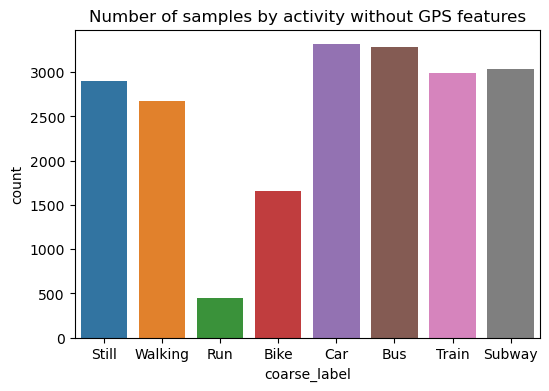

In [27]:
#plot number of annotated activities for user1_hip_sensor_without_GPS
plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(6,4))
sns.countplot(data = user1_hip_sensor_without_GPS, x = 'coarse_label')
activities = ['Still', 'Walking','Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
plt.title('Number of samples by activity without GPS features')
plt.xticks(np.arange(0,8), activities)
plt.show()

In [28]:
#checking the number of rows if we keep GPS and remove NaN values
user1_hip_sensor_with_GPS = user1_hip_sensor.dropna(subset=['mean_distance_km', 'mean_speed'])
user1_hip_sensor_with_GPS.shape

(13511, 30)

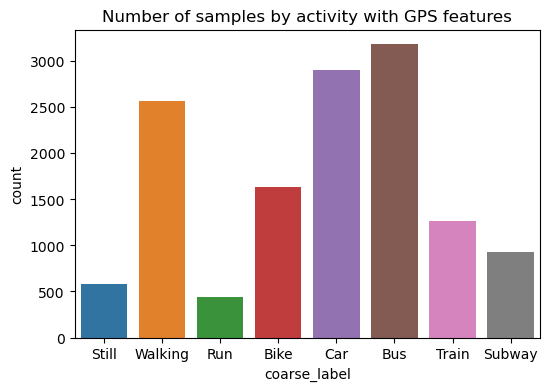

In [29]:
#plot number of annotated activities for user1_hip_sensor_with_GPS
plt.figure(figsize=(6,4))
sns.countplot(data = user1_hip_sensor_with_GPS.loc[user1_hip_sensor_with_GPS['coarse_label']!=0], x = 'coarse_label')
activities = ['Still', 'Walking','Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
plt.title('Number of samples by activity with GPS features')
plt.xticks(np.arange(0,8), activities)
plt.show()

**Notes:** By removing the GPS NaN features, this will affect the classification performance since it will result to an unbalanced dataset. Instead, the data imputation technique is prefered. 

In [30]:
user1_hip_sensor_with_GPS.columns

Index(['mean_acceleration_x', 'mean_acceleration_y', 'mean_acceleration_z',
       'std_acceleration_x', 'std_acceleration_y', 'std_acceleration_z',
       'magnitude_acceleration_xyz', 'fftfreq_acceleration_x',
       'fftfreq_acceleration_y', 'fftfreq_acceleration_z',
       'signalpower_acceleration_x', 'signalpower_acceleration_y',
       'signalpower_acceleration_z', 'entropy_acceleration_x',
       'entropy_acceleration_y', 'entropy_acceleration_z', 'mean_gyroscope_x',
       'mean_gyroscope_y', 'mean_gyroscope_z', 'std_gyroscope_x',
       'std_gyroscope_y', 'std_gyroscope_z', 'magnitude_gyroscope_xyz',
       'std_magnetometer_x', 'std_magnetometer_y', 'std_magnetometer_z',
       'magnitude_magnetometer_xyz', 'mean_distance_km', 'mean_speed',
       'coarse_label'],
      dtype='object')

### Data Imputation for GPS

For the data imputation different techniques are tested.
The function data_imputation aims to evaluate which model performs the best.

For this dataset, the IterativeImputer based on the Random Forest algorithm outperforms the other data imputation models.

In [31]:
def data_imputation(df, column):
    """                                                                                                                 
    This function evaluates different techniques for data imputation, including the IterativeImputer (MICE: Multivariate Imputation by Chained Equations in R.
    This technique models each feature with missing values as a function of other features, and uses that estimate for imputation.
    To that end, the Random Forest, kNN and Bayes algorithm are tested.
    Additionally, the traditional imputation methods based on median and linear interpolation are also tested.
    
    In order to evaluate which model performs the best, a reference feature with non missing values is used for that purpose.
    Then, the feature 'target' is randomly sampled to create NaN values.
    The evaluation is based on how accurate the data imputation is on imputing the missing values.
 
    Args:                                                                                                               
        dataframe df  
        string with the name of feature                                                              
    Returns:                                                                                                            
        the R_squared score for the model performance for imputing a certain feature and the related visualisation graph                                                                         
 
    Example:                                                                                                            
        >>> data_imputation(df_GPS, 'mean_distance_km')
    """             
    
    print ("initial shape: "+str(df.shape))
    df['reference'] = df[column].fillna(df[column].rolling(3,min_periods=1,).mean())
    df['target'] = df['reference'].sample(frac=0.7)
    
    df = df.assign(missing= np.nan)
    df.missing[df.target.isna()] = df.reference

    Rf= RandomForestRegressor(random_state=0)
    imp_RF = IterativeImputer(estimator=Rf,missing_values=np.nan, max_iter=5, verbose=2, initial_strategy = 'median', imputation_order='ascending', random_state=0)
    
    kNN= KNeighborsRegressor(n_neighbors=10)
    imp_kNN = IterativeImputer(estimator=kNN,missing_values=np.nan, max_iter=5, verbose=2, initial_strategy = 'median', imputation_order='ascending',random_state=0)
    
    model = BayesianRidge()
    imp_Bayes = IterativeImputer(estimator=model,missing_values=np.nan, max_iter=5, verbose=2, initial_strategy = 'median', imputation_order='random',random_state=0)
    
    #condition to remove first columns, user_id & time
    new_data = df.loc[:, ~df.columns.isin(['missing', 'reference', column])]
    new_data_imp_RF = pd.DataFrame(imp_RF.fit_transform(new_data), index=new_data.index, columns = new_data.columns)
    new_data_imp_kNN = pd.DataFrame(imp_kNN.fit_transform(new_data), index=new_data.index, columns = new_data.columns)
    new_data_imp_Bayes = pd.DataFrame(imp_Bayes.fit_transform(new_data), index=new_data.index, columns = new_data.columns)

    df['Imputer_RF'] = new_data_imp_RF['target']
    df['Imputer_kNN'] = new_data_imp_kNN['target']
    df['Imputer_Bayes'] = new_data_imp_Bayes['target']
    
    #imputing using the median
    df = df.assign(FillMedian=df.target.fillna(df.target.median()))
    #imputing using the Linear Interpolation
    df = df.assign(InterpolateLinear=df.target.interpolate(method='linear'))
   
    df_test = df[['reference', 'target', 'missing', 'Imputer_RF', 'Imputer_kNN' , 'Imputer_Bayes', 'FillMedian', 'InterpolateLinear']]

    df = df_test.copy()

    listx = df.columns.tolist()
    listx.remove('reference')
    listx.remove('target')
    listx.remove('missing')
    
    df = df.dropna(subset=listx)
    print ("final shape: "+str(df.shape))    

    results = [(method, r2_score(df.reference, df[method])) for method in listx]
    results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
    
    score =  results_df.sort_values(by='R_squared', ascending=False)
    score.reset_index(inplace=True)

    value = float(score.R_squared[0])
    value = math.ceil(value*100)/100 
    
    #plot a lineplot actual vs imputed values
    sns.set_theme(font_scale=2.5)
    f, ax = plt.subplots(figsize=(25,15))
    
    sns.lineplot(data=df['reference'],  ax=ax, color='k', linestyle=":", linewidth = 4)
    sns.lineplot(data=df['missing'],  ax=ax, color='k', marker="o", linestyle="", markersize=12)
    sns.lineplot(data=df[score.Method[0]],  ax=ax, color='r', linestyle="-.",  linewidth = 4)

    ax.xaxis.set_major_locator(dates.DayLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%y-%m-%d'))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels = ['reference', 'missing', str(score.Method[0])], handletextpad=0, columnspacing=1, loc="upper right", ncol=4, frameon=True)

    plt.xlabel("time", fontsize=35)
    plt.ylabel(column, fontsize=35)
    plt.title("R_squared Score for "+str(score.Method[0])+": "+str(value)  , fontsize=40)
    plt.xticks(rotation=90)
    plt.tight_layout() 
    plt.margins(tight=True)
    #sns.despine(left = True, bottom = True)
    ax.grid()
    plt.show()
    
    #plot a barplot with the score
    score['R_squared'] = score['R_squared'].astype(float)
    f, ax1 = plt.subplots(figsize=(25,15))
    ax1 = sns.barplot(x='Method', y='R_squared', data=score, palette='Blues_d')
    plt.xlabel("method")
    #plt.ylabel(column, fontsize=35)
    plt.title("Performance Score for Data Imputation Methods ("+column + ")" , fontsize=40)
    ax1.set_xticks(range(len(score))) # <--- set the ticks first
    ax1.set_xticklabels(score.Method)
    plt.xticks(rotation=90)
    plt.tight_layout() 
    plt.margins(tight=True)
    #sns.despine(left = True, bottom = True)
    plt.savefig('Data_Imputation_'+column+'.png')
    plt.show()
    
    return score

#### Data Imputation evaluation for feature 'mean_distance_km'

the data imputation methods are evaluated for the feature 'mean_distance_km'.
The dataframe 'user1_hip_sensor_with_GPS' is used for this purpose since any missing values have been removed.
The results show that the methdods 'Imputer_Bayes' and 'Imputer_RF' are the best (R_squared_Score >0.85)

In [38]:
#optional - call the function data_imputation
#optional since it is computational demanding
#data_imputation(user1_hip_sensor_with_GPS, 'mean_distance_km')

![mean_distance_km](Data_Imputation_mean_distance_km.png "mean_distance_km")

#### Data Imputation evaluation for feature 'mean_speed'

the data imputation methods are evaluated for the feature 'mean_speed'. The dataframe 'user1_hip_sensor_with_GPS' is used for this purpose, since any missing values have been removed.
The results show that the methdods 'InterpolateLinear' and 'Imputer_RF' are the best (R_squared_Score >0.95)

In [39]:
#optional - call the function data_imputation
#optional since it is computational demanding
#data_imputation(user1_hip_sensor_with_GPS, 'mean_speed')

![mean_speed](Data_Imputation_mean_speed.png "mean_speed")

### Perform Data Imputation for GPS data

In [40]:
#store actual data before the imputation of missing values 
#user1_hip_sensor_without_GPS.to_csv('user1_hip_sensor_without_GPS.csv')


In [32]:
#check what features contain missing values
user1_hip_sensor_without_GPS.isnull().sum()

mean_acceleration_x              0
mean_acceleration_y              0
mean_acceleration_z              0
std_acceleration_x               0
std_acceleration_y               0
std_acceleration_z               0
magnitude_acceleration_xyz       0
fftfreq_acceleration_x           0
fftfreq_acceleration_y           0
fftfreq_acceleration_z           0
signalpower_acceleration_x       0
signalpower_acceleration_y       0
signalpower_acceleration_z       0
entropy_acceleration_x           0
entropy_acceleration_y           0
entropy_acceleration_z           0
mean_gyroscope_x                 0
mean_gyroscope_y                 0
mean_gyroscope_z                 0
std_gyroscope_x                  0
std_gyroscope_y                  0
std_gyroscope_z                  0
magnitude_gyroscope_xyz          0
std_magnetometer_x               0
std_magnetometer_y               0
std_magnetometer_z               0
magnitude_magnetometer_xyz       0
mean_distance_km              6787
mean_speed          

In [49]:
#perform the data imputation based on the RandomForestRegressor (IterativeImputer)
#it is computational demanding (it takes ~17min)
#a csv file with the results is provided below, so this step can be skipped

Rf= RandomForestRegressor(random_state=0)
imp_RF = IterativeImputer(estimator=Rf,missing_values=np.nan, max_iter=5, verbose=2, initial_strategy = 'median', imputation_order='ascending', random_state=0)
df_imp = user1_hip_sensor_without_GPS.copy()
user1_hip_sensor_imputed = pd.DataFrame(imp_RF.fit_transform(df_imp), index=df_imp.index, columns = df_imp.columns)

user1_hip_sensor_imputed.head()

[IterativeImputer] Completing matrix with shape (20298, 30)
[IterativeImputer] Ending imputation round 1/5, elapsed time 1139.58
[IterativeImputer] Change: 2.0420209343357603, scaled tolerance: 109964.56184873922 
[IterativeImputer] Early stopping criterion reached.


,mean_acceleration_x,mean_acceleration_y,mean_acceleration_z,std_acceleration_x,std_acceleration_y,std_acceleration_z,magnitude_acceleration_xyz,fftfreq_acceleration_x,fftfreq_acceleration_y,fftfreq_acceleration_z,...,std_gyroscope_y,std_gyroscope_z,magnitude_gyroscope_xyz,std_magnetometer_x,std_magnetometer_y,std_magnetometer_z,magnitude_magnetometer_xyz,mean_distance_km,mean_speed,coarse_label
time,,,,,,,,,,,,,,,,,,,,,
2017-06-22 08:46:50,0.293839,-10.509341,-0.631124,3.496744,5.613450,6.842408,347.565732,3.833333,0.166667,2.000000,...,1.842227,0.706809,68.318213,11.307075,5.317859,11.521749,1016.559763,0.003283,0.206916,2.0
2017-06-22 08:46:53,0.113301,-10.769445,-0.527143,3.698429,6.249547,7.304300,365.116024,3.000000,0.166667,2.000000,...,1.886756,0.742172,70.079015,3.953300,5.593827,12.171854,1009.512467,0.002500,0.161870,2.0
2017-06-22 08:46:56,0.057076,-10.768269,-0.701178,3.762441,6.219880,7.403770,366.548582,1.000000,0.166667,4.833333,...,1.833078,0.782393,67.932768,3.215448,5.748253,11.399805,1036.198867,0.001600,0.100295,2.0
2017-06-22 08:46:59,0.024813,-10.787620,-0.685629,3.789772,6.401913,7.423479,369.145721,1.000000,0.166667,2.000000,...,1.935283,0.792348,69.697811,3.052362,5.639679,11.677681,1023.294098,0.001783,0.109354,2.0
2017-06-22 08:47:02,0.086053,-10.831259,-0.693373,3.855802,6.285444,7.353742,368.300253,1.000000,0.166667,4.833333,...,2.005722,0.769266,71.710834,4.539686,6.185144,11.486974,964.051829,0.001917,0.113704,2.0


### Store Data after Data Extraction

The previous step (data imputation for GPS missing values) is computational demanding since it takes ~17min.
Therefore a csv file with the results is provided below as an alternatice.
This file contains all the related features (after GPS imputation).

In [50]:
#store data to csv file with the final values (after data imputation)
#user1_hip_sensor_imputed.to_csv('user1_hip_sensor_imputed.csv')

In [34]:
#optional - read data from csv
user1_hip_sensor_imputed = pd.read_csv('user1_hip_sensor_imputed.csv', index_col=0)

In [35]:
user1_hip_sensor_imputed.shape

(20298, 30)

In [36]:
user1_hip_sensor_imputed.columns

Index(['mean_acceleration_x', 'mean_acceleration_y', 'mean_acceleration_z',
       'std_acceleration_x', 'std_acceleration_y', 'std_acceleration_z',
       'magnitude_acceleration_xyz', 'fftfreq_acceleration_x',
       'fftfreq_acceleration_y', 'fftfreq_acceleration_z',
       'signalpower_acceleration_x', 'signalpower_acceleration_y',
       'signalpower_acceleration_z', 'entropy_acceleration_x',
       'entropy_acceleration_y', 'entropy_acceleration_z', 'mean_gyroscope_x',
       'mean_gyroscope_y', 'mean_gyroscope_z', 'std_gyroscope_x',
       'std_gyroscope_y', 'std_gyroscope_z', 'magnitude_gyroscope_xyz',
       'std_magnetometer_x', 'std_magnetometer_y', 'std_magnetometer_z',
       'magnitude_magnetometer_xyz', 'mean_distance_km', 'mean_speed',
       'coarse_label'],
      dtype='object')

## Features Selection

Here the most informative features are selected.
- At first, features correlation is explored. Highy correlated features are removed. For instance, 'magnitude_acceleration_xyz' is correlated with 'signal_power_acceleration_y'. 
- Then, non-informative features are removed based on feature importance score.

### Features Correlation

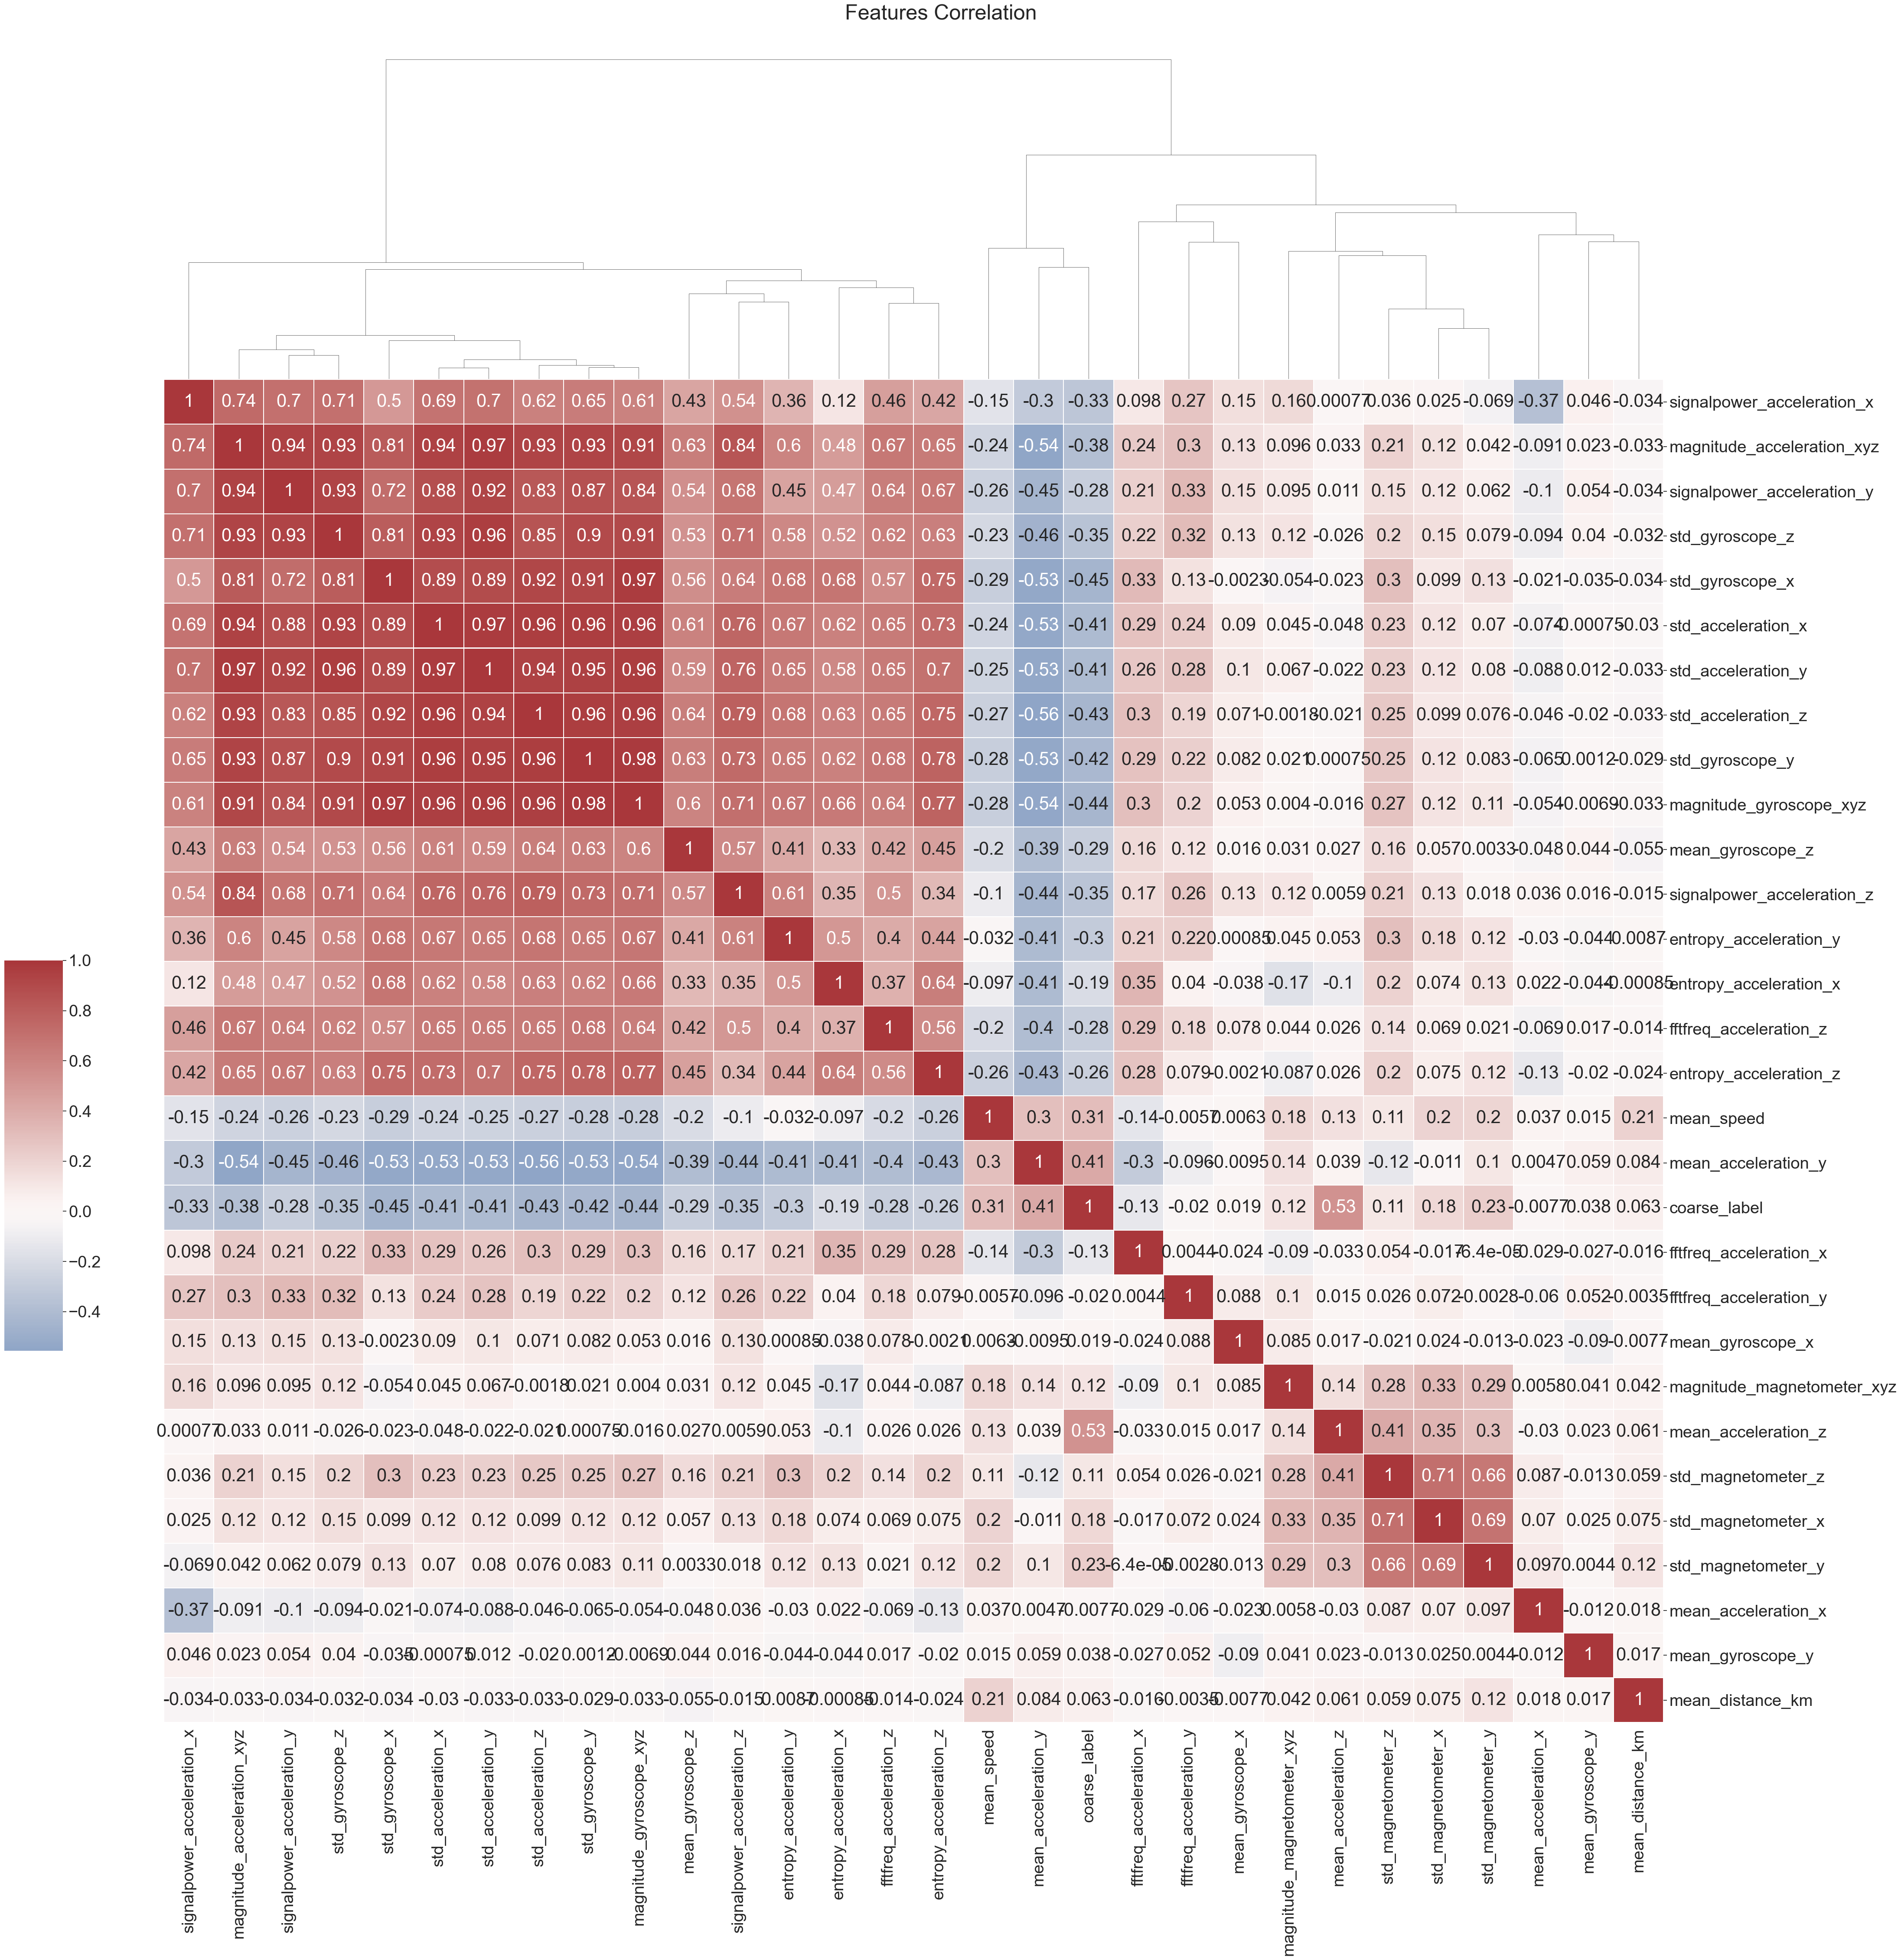

In [37]:
# Draw the full plot
sns.set_theme(font_scale=2.5)
g = sns.clustermap(user1_hip_sensor_imputed.corr(), center=0, cmap="vlag", annot=True,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(45, 45) )

g.ax_row_dendrogram.remove()
g.fig.suptitle("Features Correlation",fontsize=35, y=1.01) 
plt.show()

### Remove highly correlated features

Feautures with absolute correlation >=0.9 are removed

In [38]:
#condition for highly correlated features
df_corr = user1_hip_sensor_imputed.corr()
corr_columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if (df_corr.iloc[i,j] >= 0.9) or (df_corr.iloc[i,j] <= -0.9):
            if corr_columns[j]:
                corr_columns[j] = False

#columns with absolute correlation <0.9
df_corr_selected_columns = user1_hip_sensor_imputed.columns[corr_columns]

print("The following features will be removed: \n", user1_hip_sensor_imputed.columns[~corr_columns])

The following features will be removed: 
 Index(['std_acceleration_y', 'std_acceleration_z',
       'magnitude_acceleration_xyz', 'signalpower_acceleration_y',
       'std_gyroscope_x', 'std_gyroscope_y', 'std_gyroscope_z',
       'magnitude_gyroscope_xyz'],
      dtype='object')


In [39]:
#remove highly correlated features
user1_hip_sensor_selected_features = user1_hip_sensor_imputed[df_corr_selected_columns]
user1_hip_sensor_selected_features.head(2)

,mean_acceleration_x,mean_acceleration_y,mean_acceleration_z,std_acceleration_x,fftfreq_acceleration_x,fftfreq_acceleration_y,fftfreq_acceleration_z,signalpower_acceleration_x,signalpower_acceleration_z,entropy_acceleration_x,...,mean_gyroscope_x,mean_gyroscope_y,mean_gyroscope_z,std_magnetometer_x,std_magnetometer_y,std_magnetometer_z,magnitude_magnetometer_xyz,mean_distance_km,mean_speed,coarse_label
time,,,,,,,,,,,,,,,,,,,,,
2017-06-22 08:46:50,0.293839,-10.509341,-0.631124,3.496744,3.833333,0.166667,2.0,2.941928e+06,1.312762e+07,0.602634,...,0.061459,-0.325040,0.062587,11.307075,5.317859,11.521749,1016.559763,0.003283,0.206916,2.0
2017-06-22 08:46:53,0.113301,-10.769445,-0.527143,3.698429,3.000000,0.166667,2.0,4.410676e+06,1.621074e+07,0.564849,...,0.006140,-0.010241,0.119517,3.953300,5.593827,12.171854,1009.512467,0.002500,0.161870,2.0


### Select Informative features

Here features are evaluated for their contribution to the classification performance based on the feature importance score by Random Forest

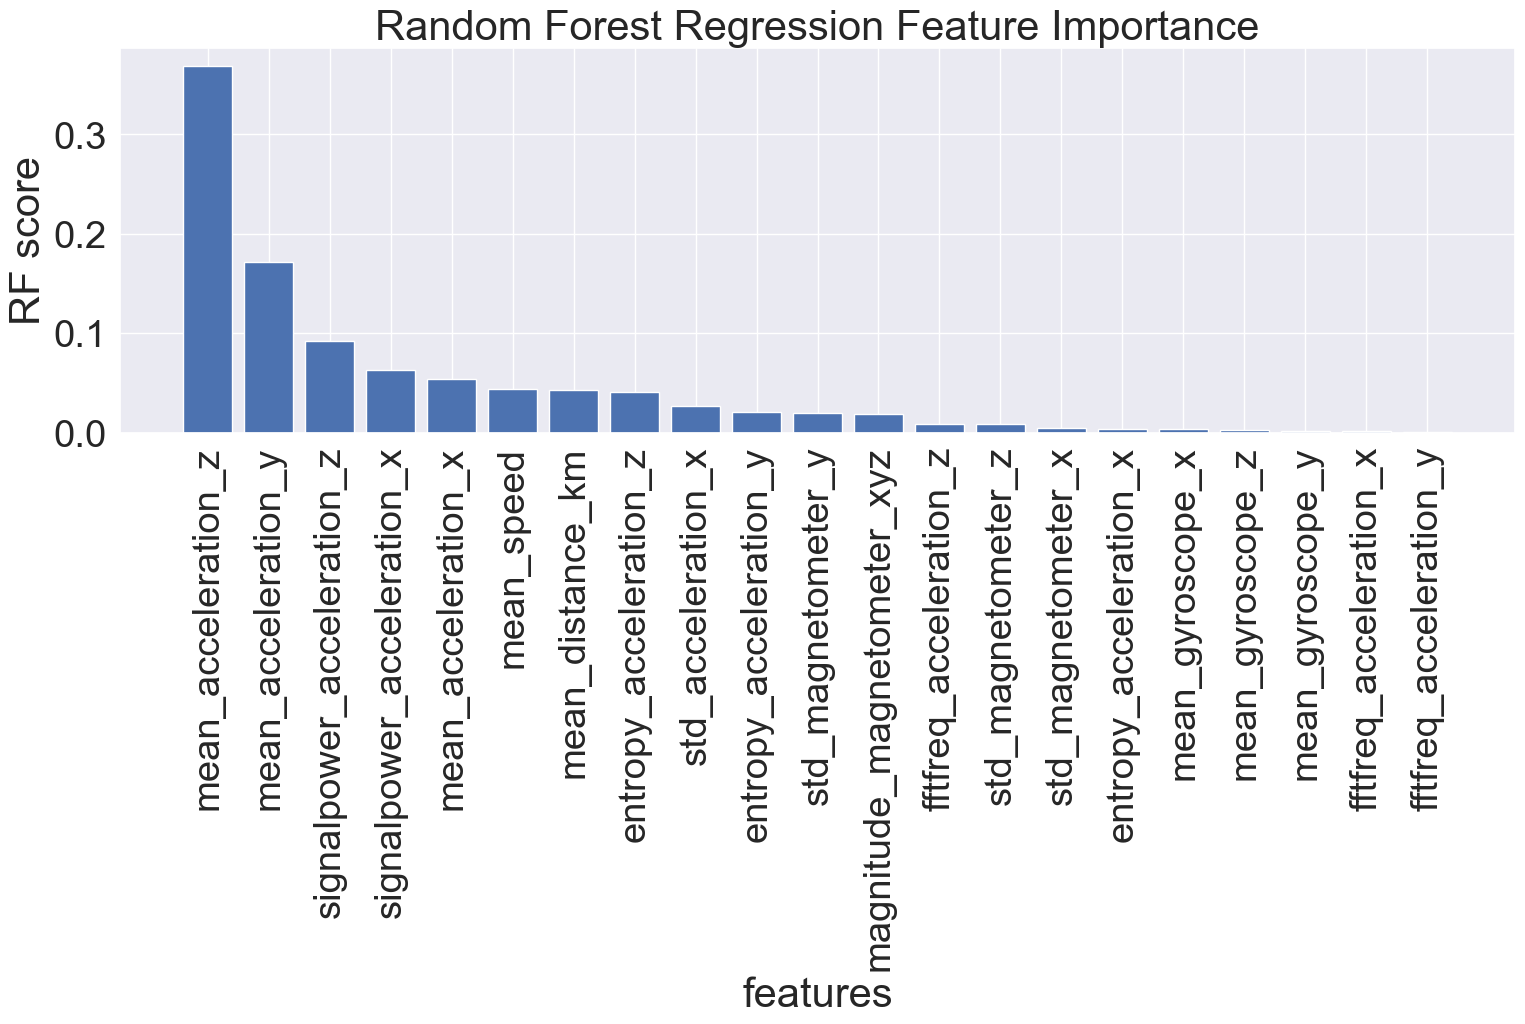

In [40]:
# feature importance based on random forest
# define train/test datasets
df_X = user1_hip_sensor_selected_features.copy() #user1_hip_sensor_imputed

df_X = df_X.loc[:, df_X.columns!='coarse_label']
#normalise data 
norm = StandardScaler()
df_X_norm = norm.fit_transform(df_X)

df_y = user1_hip_sensor_selected_features['coarse_label']

# define the model
model = RandomForestRegressor(random_state=0)
# fit the model
model.fit(df_X_norm, df_y)
# get importance
importance = model.feature_importances_

#make a dataframe with summary importance
index = np.arange(len(importance))
df_importance = pd.DataFrame(importance, index = df_X.columns)
df_importance.columns=['score']
df_importance = df_importance.sort_values(by=['score'],ascending=False)

# plot feature importance
plt.figure(figsize=(18,5))
plt.bar(index, df_importance['score'])
plt.title("Random Forest Regression Feature Importance")
plt.xticks(index, df_importance.index, rotation=90) 
plt.ylabel('RF score') 
plt.xlabel('features') 
plt.show()

In [41]:
#check score
df_importance

,score
mean_acceleration_z,0.368944
mean_acceleration_y,0.172122
signalpower_acceleration_z,0.091969
signalpower_acceleration_x,0.063464
mean_acceleration_x,0.053746
mean_speed,0.044099
mean_distance_km,0.043131
entropy_acceleration_z,0.041373
std_acceleration_x,0.026490
entropy_acceleration_y,0.020972


In [42]:
#The lowest two informative features are removed
user1_hip_sensor_selected_features = user1_hip_sensor_selected_features.loc[:, ~user1_hip_sensor_selected_features.columns.isin(['fftfreq_acceleration_x', 'fftfreq_acceleration_y'])]
user1_hip_sensor_selected_features.shape

(20298, 20)

In [43]:
user1_hip_sensor_selected_features.columns

Index(['mean_acceleration_x', 'mean_acceleration_y', 'mean_acceleration_z',
       'std_acceleration_x', 'fftfreq_acceleration_z',
       'signalpower_acceleration_x', 'signalpower_acceleration_z',
       'entropy_acceleration_x', 'entropy_acceleration_y',
       'entropy_acceleration_z', 'mean_gyroscope_x', 'mean_gyroscope_y',
       'mean_gyroscope_z', 'std_magnetometer_x', 'std_magnetometer_y',
       'std_magnetometer_z', 'magnitude_magnetometer_xyz', 'mean_distance_km',
       'mean_speed', 'coarse_label'],
      dtype='object')

### Classification & Validation

Dataset is normalised based on the StandardScaler.
Then it is randomly splitted into 10 folds (using StratifiedShuffleSplit for stratified results) with a 70% and 30% train/test ratio.
Random Forest is used for the classification.
Precision, recall, and f1-score are the metrics for evaluating the performance.

In [44]:
# define train/test datasets
df_X = user1_hip_sensor_selected_features.copy() #user1_hip_sensor_imputed
df_X = df_X.loc[:, df_X.columns!='coarse_label']

#normalise data 
norm = StandardScaler()
df_X = norm.fit_transform(df_X)

df_y = user1_hip_sensor_selected_features['coarse_label']
df_y = df_y.to_numpy()
#the random state is different from the previous steps on purpose (to avoid the possibility of biased results from the learning model)
random_num=10

total_score_pre, total_score_rec, total_score_f1 = 0, 0 , 0

#StratifiedShuffleSplit gives stratified results, ensuring the same percentage of classes as the original one
stratSplit = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=random_num)
    
for train_index, test_index in stratSplit.split(df_X, df_y):
    X_train, X_test = df_X[train_index], df_X[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    
    #Random Forest is with default values. Further hyperparameter optimisation can be applied
    rf = RandomForestClassifier(random_state=random_num)

    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    
    pre_all = precision_score(y_test, predictions, average='weighted')
    rec_all = recall_score(y_test, predictions, average='weighted')
    f1_all = f1_score(y_test, predictions, average='weighted')
    
    total_score_pre = total_score_pre + pre_all
    total_score_rec= total_score_rec + rec_all
    total_score_f1 = total_score_f1 + f1_all
    
print ("Total precision_score: ",total_score_pre/10)
print ("Total recall_score: ",total_score_rec/10)
print ("Total f1_score: ",total_score_f1/10)

Total precision_score:  0.9605007794206948
Total recall_score:  0.9603284072249589
Total f1_score:  0.9603546114197883


### Plot Confusion Matrix

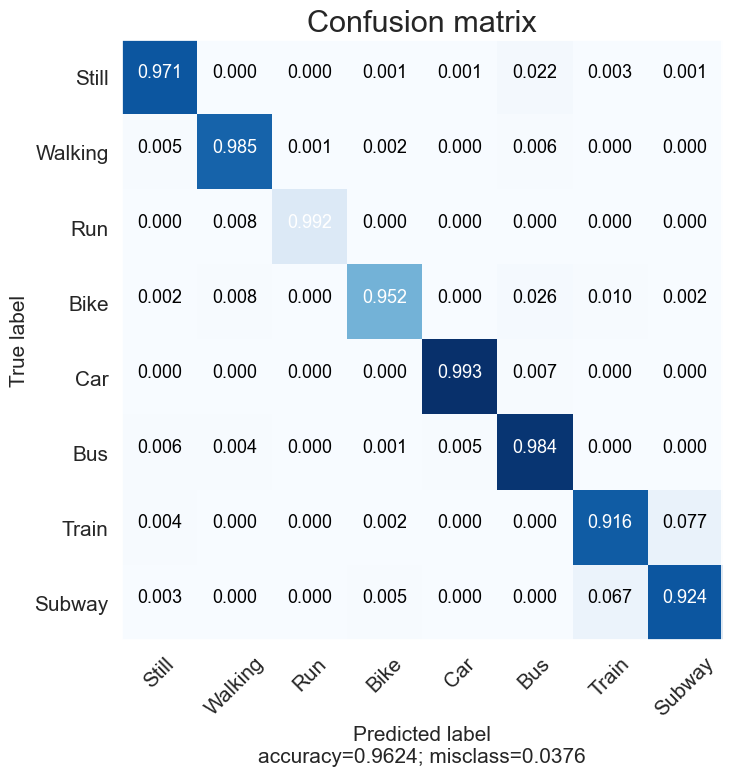

In [45]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=22)
    plt.grid(None)
    #plt.colorbar(fontsize=15)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=15)
        plt.yticks(tick_marks, target_names, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                    fontsize=13)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                    fontsize=12)


    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=15)
    plt.show()
    
#plot confusion matrix
cm = confusion_matrix(y_test, predictions)
target_names = ['Still', 'Walking','Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True)

### First Results 

The model shows an overall high performance for predicting accurately the location and transportation activities (using smartphone sensor data placed on the hip).
**Notes:** The highest score is for being in a car. Train and Subway class have been misclassified a few times

### Evaluate Performance using only acc sensor

In [69]:
#here we evaluate model performance using only accelerometer data for the classification
# define train/test datasets
df_X = user1_hip_sensor_selected_features.copy() #user1_hip_sensor_imputed
df_X = df_X[['mean_acceleration_x', 'mean_acceleration_y', 'mean_acceleration_z',
       'std_acceleration_x', 'fftfreq_acceleration_z',
       'signalpower_acceleration_x', 'signalpower_acceleration_z',
       'entropy_acceleration_x', 'entropy_acceleration_y',
       'entropy_acceleration_z']]

#normalise data 
norm = StandardScaler()
df_X = norm.fit_transform(df_X)

df_y = user1_hip_sensor_selected_features['coarse_label']
df_y = df_y.to_numpy()
#the random state is different from the previous steps on purpose (to avoid the possibility of biased results from the learning model)
random_num=10

total_score_pre, total_score_rec, total_score_f1 = 0, 0 , 0

#StratifiedShuffleSplit gives stratified results, ensuring the same percentage of classes as the original one
stratSplit = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=random_num)
    
for train_index, test_index in stratSplit.split(df_X, df_y):
    X_train, X_test = df_X[train_index], df_X[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    
    #Random Forest is with default values. Further hyperparameter optimisation can be applied
    rf = RandomForestClassifier(random_state=random_num)

    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    
    pre_all = precision_score(y_test, predictions, average='weighted')
    rec_all = recall_score(y_test, predictions, average='weighted')
    f1_all = f1_score(y_test, predictions, average='weighted')
    
    total_score_pre = total_score_pre + pre_all
    total_score_rec= total_score_rec + rec_all
    total_score_f1 = total_score_f1 + f1_all
    
print ("Total precision_score: ",total_score_pre/10)
print ("Total recall_score: ",total_score_rec/10)
print ("Total f1_score: ",total_score_f1/10)

Total precision_score:  0.9351731115584305
Total recall_score:  0.9338259441707718
Total f1_score:  0.934139592263991


### Evaluate Performance using only acc + magnetometer sensor

In [70]:
#here we evaluate model performance using only accelerometer and magnetometer data for the classification
#define train/test datasets
df_X = user1_hip_sensor_selected_features.copy() #user1_hip_sensor_imputed
df_X = df_X[['mean_acceleration_x', 'mean_acceleration_y', 'mean_acceleration_z',
       'std_acceleration_x', 'fftfreq_acceleration_z',
       'signalpower_acceleration_x', 'signalpower_acceleration_z',
       'entropy_acceleration_x', 'entropy_acceleration_y',
       'entropy_acceleration_z', 'std_magnetometer_x', 'std_magnetometer_y',
       'std_magnetometer_z', 'magnitude_magnetometer_xyz']]

#normalise data 
norm = StandardScaler()
df_X = norm.fit_transform(df_X)

df_y = user1_hip_sensor_selected_features['coarse_label']
df_y = df_y.to_numpy()
#the random state is different from the previous steps on purpose (to avoid the possibility of biased results from the learning model)
random_num=10

total_score_pre, total_score_rec, total_score_f1 = 0, 0 , 0

#StratifiedShuffleSplit gives stratified results, ensuring the same percentage of classes as the original one
stratSplit = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=random_num)
    
for train_index, test_index in stratSplit.split(df_X, df_y):
    X_train, X_test = df_X[train_index], df_X[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    
    #Random Forest is with default values. Further hyperparameter optimisation can be applied
    rf = RandomForestClassifier(random_state=random_num)

    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    
    pre_all = precision_score(y_test, predictions, average='weighted')
    rec_all = recall_score(y_test, predictions, average='weighted')
    f1_all = f1_score(y_test, predictions, average='weighted')
    
    total_score_pre = total_score_pre + pre_all
    total_score_rec= total_score_rec + rec_all
    total_score_f1 = total_score_f1 + f1_all
    
print ("Total precision_score: ",total_score_pre/10)
print ("Total recall_score: ",total_score_rec/10)
print ("Total f1_score: ",total_score_f1/10)

Total precision_score:  0.9530654553529965
Total recall_score:  0.9526929392446635
Total f1_score:  0.9527641545231621


### Evaluate Performance using only acc + magnetometer + GPS sensor

In [71]:
#here we evaluate model performance using only accelerometer, magnetometer, and GPS data for the classification
#define train/test datasets
df_X = user1_hip_sensor_selected_features.copy() #user1_hip_sensor_imputed
df_X = df_X[['mean_acceleration_x', 'mean_acceleration_y', 'mean_acceleration_z',
       'std_acceleration_x', 'fftfreq_acceleration_z',
       'signalpower_acceleration_x', 'signalpower_acceleration_z',
       'entropy_acceleration_x', 'entropy_acceleration_y',
       'entropy_acceleration_z', 'std_magnetometer_x', 'std_magnetometer_y',
       'std_magnetometer_z', 'magnitude_magnetometer_xyz','mean_distance_km',
       'mean_speed']]

#normalise data 
norm = StandardScaler()
df_X = norm.fit_transform(df_X)

df_y = user1_hip_sensor_selected_features['coarse_label']
df_y = df_y.to_numpy()
#the random state is different from the previous steps on purpose (to avoid the possibility of biased results from the learning model)
random_num=10

total_score_pre, total_score_rec, total_score_f1 = 0, 0 , 0

#StratifiedShuffleSplit gives stratified results, ensuring the same percentage of classes as the original one
stratSplit = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=random_num)
    
for train_index, test_index in stratSplit.split(df_X, df_y):
    X_train, X_test = df_X[train_index], df_X[test_index]
    y_train, y_test = df_y[train_index], df_y[test_index]
    
    #Random Forest is with default values. Further hyperparameter optimisation can be applied
    rf = RandomForestClassifier(random_state=random_num)

    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    
    pre_all = precision_score(y_test, predictions, average='weighted')
    rec_all = recall_score(y_test, predictions, average='weighted')
    f1_all = f1_score(y_test, predictions, average='weighted')
    
    total_score_pre = total_score_pre + pre_all
    total_score_rec= total_score_rec + rec_all
    total_score_f1 = total_score_f1 + f1_all
    
print ("Total precision_score: ",total_score_pre/10)
print ("Total recall_score: ",total_score_rec/10)
print ("Total f1_score: ",total_score_f1/10)

Total precision_score:  0.9615018397164267
Total recall_score:  0.9613464696223316
Total f1_score:  0.9613708152936052


### Model Performance for different sensor fusion

In [96]:
data = {'precission': [0.9352, 0.9531, 0.9615, 0.9605],
        'recall': [0.9338, 0.9527, 0.9614, 0.9603],
       'f1-score': [0.9341, 0.9528, 0.9614, 0.9604],
       'sensor':['sensor_acc', 'sensor_acc_mag', 'sensor_acc_mag_GPS', 'sensor_all']}
  
# Creates pandas DataFrame.
df_score = pd.DataFrame(data)
df_score

,precission,recall,f1-score,sensor
0,0.9352,0.9338,0.9341,sensor_acc
1,0.9531,0.9527,0.9528,sensor_acc_mag
2,0.9615,0.9614,0.9614,sensor_acc_mag_GPS
3,0.9605,0.9603,0.9604,sensor_all


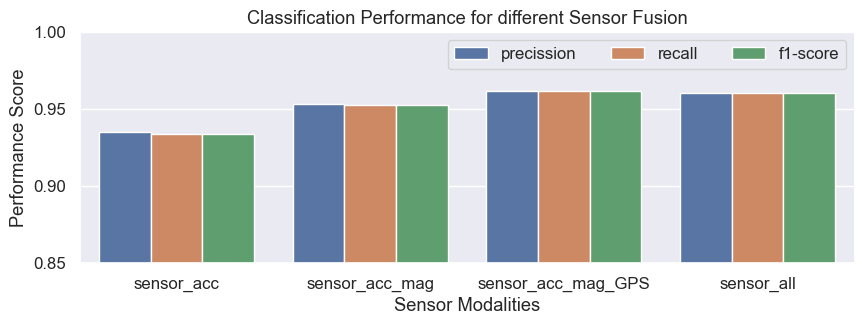

In [97]:
#plot the df_score

df_score = df_score.melt(id_vars='sensor').rename(columns=str.title)

sns.set_theme(font_scale=1.1)
fig = plt.subplots(figsize=(10, 3))
g = sns.barplot(x='Sensor', y='Value', hue='Variable', data=df_score)
g.set_ylim(0.85, 1)
g.set_title("Classification Performance for different Sensor Fusion")
g.set_ylabel("Performance Score")
g.set_xlabel("Sensor Modalities")
g.legend(ncol = 3, loc = 'upper right')

**Notes:** the accelerometer + magnitude + GPS sensor modalities seem to contribute to a better classification performance among the four sensor fusion modalities. Further investigation is required though to validate this.

### Results
For this dataset, I focused on a sensor fusion approach by using accelerometer, gyroscope, magnetometer, and GPS sensor modalities (using smartphone sensor data placed on the hip). The classification model shows an overall high performance for predicting accurately the location and transportation activities.

### Limitations
The GPS features 'speed' and 'distance' represent an estimation of the actual values and they seem to contribute to the classification performance. 

### Future Work
- consider more sensor modalities (e.g, wi-fi signal strength)
- consider a different size for window segmentation
- extract different time/frequency features
- improve classification performance (i.e., use another algorithm and/or perform hyperparameter tuning)